Proyecto: Telecom X - Etapa 1
==============================

## Abandono (Churn) de clientes

## Índice

1. Descripción del proyecto.
2. Importación de librerías y extracción de datos.
3. Análisis Exploratorio de Datos (EDA).
   - Exploración.
   - Transformación.
   - Análisis y visualización de datos.

# 1. Descripción del proyecto

Proyecto "Churn de Clientes" para la compañía Telecom X. 

La empresa enfrenta una alta tasa de cancelaciones y necesita comprender los factores que llevan a la pérdida de clientes.

Tu desafío será recopilar, procesar y analizar los datos, utilizando Python y sus principales bibliotecas para extraer información valiosa. A partir de tu análisis, el equipo de Data Science podrá avanzar en modelos predictivos y desarrollar estrategias para reducir la evasión.

# 2. Importación de librerías y extracción de datos

## Importación de librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json

from IPython.display import clear_output

## Extracción de datos

In [2]:
# API donde se encuentra los datos
url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json'

# Solicitud a la API
r = requests.get(url)

# Imprimir estado de la respuesta
print(r.status_code)
# Verificar tipo de contenido
print(r.headers['Content-type'])

# Escribir el archivo para normalización
with open('TelecomX_Data.json', 'wb') as f:
    f.write(r.content)

200
text/plain; charset=utf-8


In [3]:
# Leer el archivo
with open('TelecomX_Data.json', 'r') as f:
    raw_data = json.loads(f.read())

In [4]:
# Normalización del JSON
raw_data = pd.json_normalize(raw_data)

In [5]:
raw_data[raw_data['internet.InternetService'] == 'No']

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
20,0023-UYUPN,No,Female,1,Yes,No,50,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Electronic check,25.20,1306.3
23,0030-FNXPP,No,Female,0,No,No,3,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.85,57.2
24,0031-PVLZI,Yes,Female,0,Yes,Yes,4,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.35,76.35
27,0040-HALCW,No,Male,0,Yes,Yes,54,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),20.40,1090.6
28,0042-JVWOJ,No,Male,0,No,No,26,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),19.60,471.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7250,9970-QBCDA,No,Female,0,No,No,6,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),19.70,129.55
7252,9972-EWRJS,No,Female,0,Yes,Yes,67,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),19.25,1372.9
7256,9975-GPKZU,No,Male,0,Yes,Yes,46,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),19.75,856.5
7257,9975-SKRNR,No,Male,0,No,No,1,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,18.90,18.9


In [6]:
# Guardar el archivo JSON normalizado
raw_data.to_json('TelecomX_Data_norm.json')

In [7]:
columnas = raw_data.columns
columnas

Index(['customerID', 'Churn', 'customer.gender', 'customer.SeniorCitizen',
       'customer.Partner', 'customer.Dependents', 'customer.tenure',
       'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract',
       'account.PaperlessBilling', 'account.PaymentMethod',
       'account.Charges.Monthly', 'account.Charges.Total'],
      dtype='object')

In [8]:
nuevas_columnas = [
    columnas
    .str.replace('customer.', '')
    .str.replace('phone.', '')   
    .str.replace('internet.', '')
    .str.replace('account.', '').tolist()
]

In [9]:
nuevas_columnas

[['customerID',
  'Churn',
  'gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'tenure',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'Charges.Monthly',
  'Charges.Total']]

In [10]:
# Crear copia para mantener datos en su estado original por si se necesitan
df = raw_data.copy()

# Utilizar la lista con las columnas con nombres normalizados
df.columns = nuevas_columnas[0]

# 3. Análisis Exploratorio de Datos (EDA)

## 3.1 Exploración y Transformación de datos

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 non-null   object 


### Observaciones:

El conjunto de datos al parecer no presenta valores nulos *(Missing values)*.<br>
Sin embargo, podemos observar que si bien `'Charges.Monthly'` tiene tipo de dato `float64`, `'Charges.Total'` no ha sido tomada como columna numérica, a pesar de que a simple vista parece contener solo información numérica. Esto puede deberse a que haya valores mal cargados. Por lo que habrá que investigar más en detalle esta columna.

### Variables numéricas

In [12]:
# Intentar convertir la columna a tipo coma flotante para ver que error arroja
#df['Charges.Total'].astype(np.float64)

El error obtenido indica que no se puede convertir `' '` en `float64`.
Por lo que inicialmente reemplazaré dicho string por 0 e intentar ejecutar el código anterior nuevamente para ver si esto soluciona el problema

In [13]:
df[df['Charges.Total'] == ' ']

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
975,1371-DWPAZ,No,Female,0,Yes,Yes,0,No,No phone service,DSL,...,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,
1775,2520-SGTTA,No,Female,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,
1955,2775-SEFEE,No,Male,0,No,Yes,0,Yes,Yes,DSL,...,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,
2075,2923-ARZLG,No,Male,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,
2232,3115-CZMZD,No,Male,0,No,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,
2308,3213-VVOLG,No,Male,0,Yes,Yes,0,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,
2930,4075-WKNIU,No,Female,0,Yes,Yes,0,Yes,Yes,DSL,...,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,
3134,4367-NUYAO,No,Male,0,Yes,Yes,0,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,
3203,4472-LVYGI,No,Female,0,Yes,Yes,0,No,No phone service,DSL,...,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,
4169,5709-LVOEQ,No,Female,0,Yes,Yes,0,Yes,No,DSL,...,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,


In [14]:
df[df['Charges.Total'] == ' '].index == df[df['tenure'] == 0].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

#### Observaciones: Valores faltantes `Charges.Total`

Es posible observar que los valores faltantes en Charge.Total pertenecen a aquellos contratos nuevos que aun no tienen siquiera un mes de antiguedad, por lo que aun no se les ha cobrado por el servicio, lo que lleva a que no tengan nada en dicha columna.
Esto sera solucionado reemplazando el espacio en blanco por 0.

In [15]:
df['Charges.Total'] = df['Charges.Total'].replace(' ', '0')

In [16]:
df['Charges.Total'] = df['Charges.Total'].astype(np.float64)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 non-null   object 


### 3.1.2 Variables categóricas

Lo primero será verificar que la columna `customerID` tenga la misma cantidad de valores únicos como filas en el DataFrame

In [18]:
len(df['customerID'].unique())

7267

Se puede observar que la columna `customerID` cuenta con 7267 valores unicos, que es exactamente la cantidad de registros en el DataFrame, lo que quiere decir que no hay registros duplicados.

In [19]:
df.columns

Index(['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly',
       'Charges.Total'],
      dtype='object')

In [20]:
columnas_categoricas = ['Churn', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod']
for columna in columnas_categoricas:
    print(f'Valores unicos en columna {columna}:\n{df[columna].unique()}\n')

Valores unicos en columna Churn:
['No' 'Yes' '']

Valores unicos en columna gender:
['Female' 'Male']

Valores unicos en columna SeniorCitizen:
[0 1]

Valores unicos en columna Partner:
['Yes' 'No']

Valores unicos en columna Dependents:
['Yes' 'No']

Valores unicos en columna PhoneService:
['Yes' 'No']

Valores unicos en columna MultipleLines:
['No' 'Yes' 'No phone service']

Valores unicos en columna InternetService:
['DSL' 'Fiber optic' 'No']

Valores unicos en columna OnlineSecurity:
['No' 'Yes' 'No internet service']

Valores unicos en columna OnlineBackup:
['Yes' 'No' 'No internet service']

Valores unicos en columna DeviceProtection:
['No' 'Yes' 'No internet service']

Valores unicos en columna TechSupport:
['Yes' 'No' 'No internet service']

Valores unicos en columna StreamingTV:
['Yes' 'No' 'No internet service']

Valores unicos en columna StreamingMovies:
['No' 'Yes' 'No internet service']

Valores unicos en columna Contract:
['One year' 'Month-to-month' 'Two year']

Valores 

#### Observaciones iniciales: Variables categóricas

* La variable `Churn` tambien presenta valores incomplentos, solo que estan disfrazados por `' '`, por eso no fueron captados en el comando `df.info()`
* La variable `SeniorCitizen` tiene valores `0 y 1`. Esto resulta inconsistente con el resto de variables que toman valores `Yes` y `No`. Si bien el formato de esta columna sería el correcto para el equipo de Data Science, temporalmente mantendré el formato del resto de columnas ya que estaré analizando carácteristicas, al final entregaré el conjunto de datos con las variables mapeadeas correctamente para su utilización en modelos predictivos.
* Otra observación es que existe cierta información que puede resultar redundante. Todas los clientes que tengan `InternetService == 'No'`, tendrán las columnas `[OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies] == 'No internet service'`. Para mantener una uniformidad categórica, simplemente cambiaré ese `'No internet service'` por `'No'`. Lo mismo para la columna `MultipleLines` donde el valor es `No phone service`

In [21]:
# Mapeo columna SeniorCitizen
df['SeniorCitizen'] = df['SeniorCitizen'].apply(lambda row: 'Yes' if row == 1 else 'No')

In [22]:
int_service_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies']

In [23]:
df['MultipleLines'] = df['MultipleLines'].apply(lambda row: row.replace('No phone service', 'No'))

In [24]:
for columna in int_service_columns:
    df[columna] = df[columna].apply(lambda row: row.replace('No internet service', 'No'))

In [25]:
columnas_categoricas = ['Churn', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod']
for columna in columnas_categoricas:
    print(f'Valores unicos en columna {columna}:\n{df[columna].unique()}\n')

Valores unicos en columna Churn:
['No' 'Yes' '']

Valores unicos en columna gender:
['Female' 'Male']

Valores unicos en columna SeniorCitizen:
['No' 'Yes']

Valores unicos en columna Partner:
['Yes' 'No']

Valores unicos en columna Dependents:
['Yes' 'No']

Valores unicos en columna PhoneService:
['Yes' 'No']

Valores unicos en columna MultipleLines:
['No' 'Yes']

Valores unicos en columna InternetService:
['DSL' 'Fiber optic' 'No']

Valores unicos en columna OnlineSecurity:
['No' 'Yes']

Valores unicos en columna OnlineBackup:
['Yes' 'No']

Valores unicos en columna DeviceProtection:
['No' 'Yes']

Valores unicos en columna TechSupport:
['Yes' 'No']

Valores unicos en columna StreamingTV:
['Yes' 'No']

Valores unicos en columna StreamingMovies:
['No' 'Yes']

Valores unicos en columna Contract:
['One year' 'Month-to-month' 'Two year']

Valores unicos en columna PaperlessBilling:
['Yes' 'No']

Valores unicos en columna PaymentMethod:
['Mailed check' 'Electronic check' 'Credit card (auto

In [26]:
df[df['Churn'] == '']

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
30,0047-ZHDTW,,Female,No,No,No,11,Yes,Yes,Fiber optic,...,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),79.00,929.30
75,0120-YZLQA,,Male,No,No,No,71,Yes,No,No,...,No,No,No,No,No,Two year,Yes,Credit card (automatic),19.90,1355.10
96,0154-QYHJU,,Male,No,No,No,29,Yes,No,DSL,...,Yes,No,Yes,No,No,One year,Yes,Electronic check,58.75,1696.20
98,0162-RZGMZ,,Female,Yes,No,No,5,Yes,No,DSL,...,Yes,No,Yes,No,No,Month-to-month,No,Credit card (automatic),59.90,287.85
175,0274-VVQOQ,,Male,Yes,Yes,No,65,Yes,Yes,Fiber optic,...,Yes,Yes,No,Yes,Yes,One year,Yes,Bank transfer (automatic),103.15,6792.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7158,9840-GSRFX,,Female,No,No,No,14,Yes,Yes,DSL,...,Yes,No,No,No,No,One year,Yes,Mailed check,54.25,773.20
7180,9872-RZQQB,,Female,No,Yes,No,49,No,No,DSL,...,No,No,No,Yes,No,Month-to-month,No,Bank transfer (automatic),40.65,2070.75
7211,9920-GNDMB,,Male,No,No,No,9,Yes,Yes,Fiber optic,...,No,No,No,No,No,Month-to-month,Yes,Electronic check,76.25,684.85
7239,9955-RVWSC,,Female,No,Yes,Yes,67,Yes,No,No,...,No,No,No,No,No,Two year,Yes,Bank transfer (automatic),19.25,1372.90


In [27]:
print(f'Porcentaje de Valores faltantes en etiqueta objetivo: {round(224 / df.shape[0] * 100,2)}%')

Porcentaje de Valores faltantes en etiqueta objetivo: 3.08%


#### Observaciones:

Ya que lo que se busca analizar es justamente el **Churn** de clientes, completar 224 registros sería perjudicar el análisis, ya que esto es análisis de datos, no predicción, por lo que estoy analizando lo "historico", no puedo inferir si estos tienen `Churn == Yes` o `Churn == No`.<br> 
Se podrían aplicar técnicas de ML no supervisado como KMeans para etiquetar los datos, pero por lo pronto dejaré estos registros almacenados en una variable aparte para no descartarlos por completo.

In [28]:
df_churn = df.copy()
df_unknown = df_churn.query('Churn != "Yes" & Churn != "No"')
df_churn = df_churn.query('Churn == "Yes" | Churn == "No"')
df_unknown['Churn'] = df_unknown['Churn'].apply(lambda row: row.replace('', 'Unknown'))

In [29]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Churn             7043 non-null   object 
 2   gender            7043 non-null   object 
 3   SeniorCitizen     7043 non-null   object 
 4   Partner           7043 non-null   object 
 5   Dependents        7043 non-null   object 
 6   tenure            7043 non-null   int64  
 7   PhoneService      7043 non-null   object 
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  Contract          7043 non-null   object 
 17  

In [30]:
df_churn.describe()

,tenure,Charges.Monthly,Charges.Total
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


## 3.2 Análisis y visualización de datos

Para comprender mejor los factores que influyen en el abandono de clientes en la empresa Telecom X, se plantean las siguientes preguntas orientadoras del análisis:

**Antigüedad y facturación**

1. ¿Existe relación entre la antigüedad del cliente y el abandono?
2. ¿Existe relación entre el gasto mensual del cliente y su tendencia a dejar la empresa?
3. ¿Existe relación en el gasto total a lo largo del ciclo de vida del cliente en la empresa y la posiblidad de abandono?

**Servicios**

4. ¿Los clientes que tienden a abandonar la empresa cuentan con servicio de teléfono, internet o ambos?
5. ¿Existe relación entre la cantidad de servicios contratados y el abandono del cliente?

**Perfil del cliente**

6. ¿Algún género tiene más tendencia a dejar la empresa?
7. ¿La edad (específicamente ser un ciudadano mayor), influye en la posibilidad de que un cliente abandone?
8. ¿Existe relación entre la situación familiar del cliente *(pareja, personas a cargo)* y la posibilidad de abandono?

### Antigüedad y facturación

#### 📌 1. ¿Existe relación entre la antigüedad del cliente y el abandono?

Este será el primer análisis ya que la relación entre la antigüedad del cliente y su tendencia a dejar la empresa ofrecerá un panorama general para entender que segmento (antiguos o nuevos) es más propenso a irse.

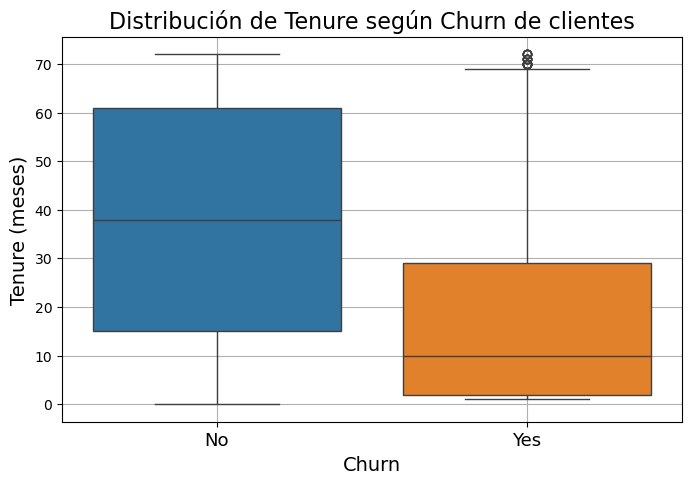

In [31]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_churn, x='Churn', y='tenure', hue='Churn', palette='tab10')
plt.title('Distribución de Tenure según Churn de clientes', fontsize=16)
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Tenure (meses)', fontsize=14)
plt.xticks(fontsize=13)
plt.grid(True)
plt.show()

#### Observaciones: Boxplot de Tenure (antigüedad) según Churn (abandono) de clientes.

**`Boxplot de Churn == 'Yes'`**

*Características*:
* Los lados de la caja van de los valores 2 hasta 29 meses aproximadamente
* Mediana ubicada en el valor 10
* El bigote inferior se encuentra en el valor 1 y el bigote superior en 69 aproximadamente, con unos cuantos valores atípicos *(outliers)* por encima.

*Interpretación:*

* La caja es más compacta a comparación del Boxplot de `Churn == 'No'` lo que indica una distribución más concentrada.
* **Mediana = 10**: el 50% de los clientes que abandonan la empresa lo hacen con 10 meses o menos de antigüedad.
* **El tercer cuartil (Q3)** se ubica en 29 meses, lo que indica que el 75% de los clientes que se dan de baja lo hacen antes de cumplir 30 meses con la empresa.

**`Boxplot de Churn == 'No'`**

*Características*

* La caja se extiende desde los 16 hasta los 61 meses aproximadamente.
* La mediana está en torno a los 38 meses.
* El bigote inferior llega hasta 0 y el bigote superior hasta 72.  

*Interpretación:*

* La distribución es más simétrica y extendida, indicando una mayor variabilidad en los clientes que permanecen en la empresa.
* La mediana de 38 sugiere que la mitad de los clientes más leales tienen más de 3 años de antigüedad.


**Conclusiones:**

* Existe una fuerte tendencia al abandono entre los clientes nuevos. La mayoría de las bajas ocurren antes del primer año.
* Sería interesante analizar las diferencias entre clientes con `tenure` entre 16 y 30 meses, para entender qué factores podrían estar influyendo en la retención o abandono en ese período intermedio.
* Asimismo, conviene estudiar el perfil de los clientes con menos de 15 meses de antigüedad, para identificar posibles oportunidades de mejora en la experiencia inicial del cliente.

#### 📌 2. ¿Existe relación entre el gasto mensual del cliente y su tendencia a dejar la empresa?

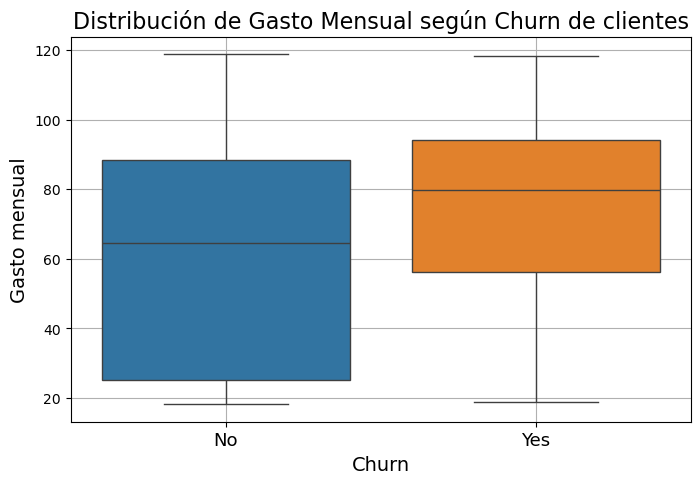

In [32]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_churn, x='Churn', y='Charges.Monthly', hue='Churn', palette='tab10')
plt.title('Distribución de Gasto Mensual según Churn de clientes', fontsize=16)
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Gasto mensual', fontsize=14)
plt.xticks(fontsize=13)
plt.grid(True)
plt.show()

#### Observaciones: Boxplot de Charges.Monthly (gasto mensual) según Churn (abandono) de clientes.

`Boxplot de Churn == 'Yes'`

*Características:*

* El 50% *(Q1 a Q3)* de los clientes que abandonan la empresa gastan entre 56 y 95 dólares aproximadamente *(limites de la caja)*.
* Mediana ~79.
* No existen valores atípicos.

*Interpretación:*

* La caja de `Churn == 'Yes'` es más compacta que la de `Churn == 'No'` al igual que en el análisis anterior, esto quiere decir que la distribución de los clientes que abandonan la empresa es más concentrada que los que no lo hacen. Lo que podría indicar que el gasto mensual del cliente es un gran influyente en relación al abandono.
* **Mediana ~79**: 50% del total de clientes que dejan la empresa gasta entre ~19 USD y ~79 USD de manera mensual.
* **Primer cuartil (Q1) y Mediana (Q2)**: La dispersión en este rango es más amplia, siendo entre 56 USD y 79 USD mensuales, lo que implica que la variedad en cuanto a la disconformidad de precio en este rango puede deberse a varias razones.
* **Tercer cuartil (Q3):** Como se vio anteriormente, el 50% de los clientes que abandonan la empresa gastan hasta 79 USD mensuales, y el 75% de los clientes que la empresa pierde gasta entre 79 USD y 90 USD.


`Boxplot de Churn == 'No'`

*Características:*

* El gasto mensual de los clientes que deciden mantenerse en la empresa se eleva hasta los ~88 USD mensuales *(Q3)*.
* Mediana ~65.
* No existen valores atípicos.


*Interpretación*

* **Mediana ~65:** El 50% de clientes que deciden quedarse gastan hasta 65 USD mensuales.
* **Rango intercuartílico (IQR):** La dispersion de los clientes que se mantienen en la empresa es más dispersa en comparación a aquellos que deciden abandonar, en un rango de aproximadamente 53 USD mensuales (88 USD - 25 USD). Esto los clientes que deciden quedarse están conformes con el precio que pagan por los serivicios adquiridos mensualmente.

**Conclusiones:**

* La variedad en cuanto a la disconformidad de los precios entre 56 y 79 USD mensuales, puede derivar en el análisis de tipo y cantidad de servicios de cada cliente y el precio que paga mensualmente, para entender por qué deciden dejar la empresa.
* La concentración de registros con un gasto entre 79 y 96 USD mensuales resulta crítica ya que una diferencia de 11 USD mensaules abarca una cuarta parte de los clientes que abandonan la empresa, por lo que la empresa podría ajustar su precificación o generar promociónes que ayuden a la permanencia del cliente hasta los 18 meses aproximadamente, ya que en el análisis anterior fue posible observar que los clientes con más de 16 meses de permanencia en la empresa tienden a quedarse.
* Es posible observar que la mediana de los clientes que deciden abandonar la empresa *(Churn = 'Yes')* segun el gasto mensual en el que incurren, coincide con aproximadamente el 68% de los clientes que deciden quedarse. Lo que sugiere que aquellos clientes con un gasto mensual mayor a 79USD son clientes con riesgo potencial a abandonar la empresa.


#### 📌 3. ¿Existe relación en el gasto total a lo largo del ciclo de vida del cliente en la empresa y la posiblidad de abandono?

### Servicios

#### 📌 4. ¿Los clientes que tienden a abandonar la empresa cuentan con servicio de teléfono, internet o ambos?


#### 📌 5. ¿Existe relación entre la cantidad de servicios contratados y el abandono del cliente?

### Perfil del cliente

#### 📌 6. ¿Algún género tiene más tendencia a dejar la empresa?

#### 📌 7. ¿La edad (específicamente ser un ciudadano mayor), influye en la posibilidad de que un cliente abandone?

#### 📌 8. ¿Existe relación entre la situación familiar del cliente *(pareja, personas a cargo)* y la posibilidad de abandono?

In [33]:
lista = [10, 20, 21, 21, 23, 27, 30, 38, 43, 45, 45, 60, 72, 73, 75, 80, 91, 93, 95, 97]
numeros = pd.DataFrame({'numeros': lista})

In [34]:
numeros.median()

numeros    45.0
dtype: float64

In [35]:
numeros.quantile(0.25)

numeros    26.0
Name: 0.25, dtype: float64

In [36]:
(10 + 20 + 21 + 21 + 23 + 27 + 30 + 38 + 43 + 45) / 10

27.8

In [37]:
numeros.quantile(0.75)

numeros    76.25
Name: 0.75, dtype: float64

In [38]:
numeros.sum() / 20

numeros    52.95
dtype: float64

In [39]:
numeros.describe()

,numeros
count,20.000000
mean,52.950000
std,29.299677
min,10.000000
25%,26.000000
50%,45.000000
75%,76.250000
max,97.000000
